## National Institute of Technology Karnatata, Surathkal
## Department of Electronics and Communication Engg.

## DL Lab : LeNet

###### Authors : Anirudh BH (16EC105), Manan Sharma (16EC118)

Import all Essential Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

#Library to show progress bar and time remaining while training
from tqdm.notebook import tqdm

#Using sklearn for downloading MNIST dataset
from sklearn.datasets import fetch_openml
#Using sklearn for train-test split and to print classification report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Import Data

In [2]:
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Convolutional Layer

**Initializer :**<br/>
1) in_channel  : Channel Size of the Input<br/>
2) out_channel : Channel Size of the Output<br/>
3) kernel_size : Filter Size for the kernel<br/>
4) stride      : Stride step size for the kernel<br/>
5) pad         : Input padding sepcifications. The same number of 0's is padded on both sides<br/>

**Methods :** <br/>
1) forward : Forward Propogation of the model<br/>
2) backward : Backward Propogation of the Loss and Gradient Descent Update<br/>
3) zero_pad : Padding the inuput to preserve/expand dimensions<br/>
4) cov_single_step : The main function for the forward convolution of a given windowed input. Window size = kernel filter size<br/>

In [3]:
class ConvLayer:
    def __init__(self, in_channel, out_channel, kernel_size, stride, pad):
        # Current Implementation is targeted square filters
        assert type(kernel_size) == int , "Kernel Error, Enter a scalar of type Int" 
        # Initialze the weights and bias associated with the layer
        self.W = np.random.randn(kernel_size, kernel_size, in_channel, out_channel).astype(float)
        self.b = np.random.randn(1,1,1,out_channel).astype(float)
        # Class Attributes
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad 

    def zero_pad(self, X):
        '''
        Input
        X : Input from the previous layer/Original Image input
        
        Output
        X_pad : Padded version of the input
        
        Operation
        Pad both sides of the input X with the specified number of zeros
        '''
        X_pad = np.pad(X,((0,0),(self.pad,self.pad), (self.pad,self.pad),(0,0)), mode='constant', constant_values = (0,0))
        return X_pad

    def conv_single_step(self, a_slice_prev, weights, bias):
        '''
        Inputs
        a_slice_prev : The windowed version of the input. Window Length = filter size
        weights      : The filter kernel for the input. Size = kernel_size, kernel_size, in_channel
        bias         : Bias associated with the filter
        
        Output
        Z : Output of the convolution operation
        
        Operation
        Pointwise-multiplication of the sliced input and the filter. 
        The elements of the multiplied output is summed and the bias term is added
        '''
        s = a_slice_prev* weights
        Z = np.sum(s)
        Z = Z + float(bias)
        return Z

    def forward(self, A_prev):
        '''
        Input
        A_prev : The input to the current layer(output of the previous layer + activation)
        
        Output
        Z : The output of the 2D linear Convolution operation
        
        Operation
        First the input is windowed/sliced. The window length used is specified from the Initializer
        The sliced input is taken and a single filter is applied . The output is a single entry into the output array
        This step is repeated for all channels. A total of out_channel number of filters are present
        The above step is then repeated for all the rows and columns of the output array
        
        Note: We store the input to the layer as well for backprop
        '''
        (m, n_H_prev, n_W_prev, _) = A_prev.shape 
        n_H = int((n_H_prev - self.kernel_size + 2 * self.pad) / self.stride) + 1
        n_W = int((n_W_prev - self.kernel_size + 2 * self.pad) / self.stride) + 1
        Z = np.zeros((m, n_H, n_W, self.out_channel))
        if self.pad == 0:
            A_prev_pad = A_prev
        else:
            A_prev_pad = self.zero_pad(A_prev)
        
        for i in range(m):
            a_prev_pad = A_prev_pad[i,:,:,:]
            for h in range(n_H):
                vert_start = h * self.stride
                vert_end = vert_start + self.kernel_size
                
                for w in range(n_W):
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + self.kernel_size
                    
                    for c in range(self.out_channel):
                        a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                        weights = self.W[...,c]
                        biases = self.b[...,c]
                        Z[i, h, w, c] = self.conv_single_step(a_slice_prev, weights, biases)
        assert(Z.shape == (m, n_H, n_W, self.out_channel))
        self.prev = A_prev
        return Z
        
    def backward(self, dZ, learning_rate=0.001):
        '''
        Input
        dZ : Derivative of the Loss function wrt the output of the current layer
        learning_rate : The step size for the gradient update.
        
        Output
        dA_prev : The derivative of the loss function wrt the previous layer output
        
        Operation
        The derivative of the loss wrt the previous layer's ouput is caculated from the derivative wrt the output of the current layer
        This is calculated using the Chain Rule
        Along with the derivative wrt the previous layer, the deriavte wrt the weights and bias of the current layer is calculated
        The calculated weight and bias gradients are used for the gradient descent update
        
        Stored Values from Forward Propogation
        self.prev : Input to the current layer for forward propogation
        '''
        A_prev = self.prev
        (m, n_H_prev, n_W_prev, _) = A_prev.shape
        (m, n_H, n_W, _) = dZ.shape
        dA_prev = np.zeros((m, n_H_prev, n_W_prev, self.in_channel))   
        dW = np.zeros((self.kernel_size, self.kernel_size, self.in_channel, self.out_channel))
        db = np.zeros((1, 1, 1, self.out_channel))
        if self.pad == 0:
            A_prev_pad = A_prev
            dA_prev_pad = dA_prev
        else:
            A_prev_pad = self.zero_pad(A_prev)
            dA_prev_pad = self.zero_pad(dA_prev)
        
        for i in range(m):
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]
            
            for h in range(n_H):
                for w in range(n_W):
                    for c in range(self.out_channel):
                        vert_start = h * self.stride
                        vert_end = vert_start + self.kernel_size
                        horiz_start = w * self.stride
                        horiz_end = horiz_start + self.kernel_size
                        a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                        da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += self.W[:,:,:,c] * dZ[i, h, w, c]
                        dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                        db[:,:,:,c] += dZ[i, h, w, c]
            if self.pad == 0:
                dA_prev[i, :, :, :] = da_prev_pad
            else :
                dA_prev[i, :, :, :] = da_prev_pad[self.pad:-self.pad, self.pad:-self.pad, :]
        assert(dA_prev.shape == (m, n_H_prev, n_W_prev, self.in_channel))
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return dA_prev

# Pooling Layer

**Initializer :**<br/>
1) kernel_size : Filter Size for the kernel<br/>
2) stride      : Stride step size for the kernel<br/>
3) mode        : Pooling type sepcifications<br/>

**Methods :** <br/>
1) forward : Forward Propogation of the model<br/>
2) backward : Backward Propogation of the Loss and Gradient Descent Update<br/>
3) create_mask_from_window : Create the mask to find the max element for backprop of Max Pool<br/>

In [4]:
class PoolLayer:
    def __init__(self, kernel_size, stride, mode = 'max'):
        self.kernel_size = kernel_size
        self.stride = stride
        # mode can only be average or max
        self.mode = mode

    def create_mask_from_window(self, x):
        '''
        Input
        x : Sliced/Windowed Input
        
        Output
        A mask with the index of the max element as 1 and remaining elments as 0
        
        Operation
        Returns an mask/array of the same dimensions as the input
        The array has a value of 1 at the position of the maximum element and 0 otherwise
        It is essential for max pooling. It is not used in the average pooling mode
        '''
        return (x==np.max(x)).astype(float)
    
    def forward(self, A_prev):
        '''
        Input
        A_prev : The input to the current layer(output of the previous layer + activation)
        
        Output
        A : The output of the 2D Max/Avg Pooling operation
        
        Operation
        First the input is windowed/sliced. The window length used is specified from the Initializer
        The sliced input is either averaged or the maximum element is taken depending on the mode
        The above step is then repeated for all the entire input array
        
        Note: We store the input to the layer as well for backprop
        '''
        (m, n_H_prev, n_W_prev, n_C) = A_prev.shape
        n_H = int(1 + (n_H_prev - self.kernel_size) / self.stride)
        n_W = int(1 + (n_W_prev - self.kernel_size) / self.stride)
        A = np.zeros((m, n_H, n_W, n_C))              

        for i in range(m):
            for h in range(n_H):
                vert_start = h*self.stride
                vert_end = vert_start + self.kernel_size
                
                for w in range(n_W):
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + self.kernel_size
                    
                    for c in range (n_C):
                        a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                        if self.mode == "max":
                            A[i, h, w, c] = np.max(a_prev_slice)
                        elif self.mode == "average":
                            A[i, h, w, c] = np.mean(a_prev_slice)        
        assert(A.shape == (m, n_H, n_W, n_C))
        self.prev = A_prev
        return A

    def backward(self, dA, **kwargs):
        '''
        Input
        dA : Derivative of the Loss function wrt the output of the current layer
        
        Output
        dA_prev : The derivative of the loss function wrt the previous layer output
        
        Operation
        The derivative of the loss wrt the previous layer's ouput is caculated from the derivative wrt the output of the current layer
        This is calculated using the Chain Rule
        
        Stored Values from Forward Propogation
        self.prev : Input to the current layer for forward propogation
        '''
        A_prev = self.prev
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        m, n_H, n_W, n_C = dA.shape
        dA_prev = np.zeros_like(A_prev)
        for i in range(m):
            a_prev = A_prev[i]
            
            for h in range(n_H):
                for w in range(n_W):
                    for c in range(n_C):
                        vert_start = h * self.stride
                        vert_end = vert_start + self.kernel_size
                        horiz_start = w * self.stride
                        horiz_end = horiz_start + self.kernel_size
                        if self.mode == "max":
                            a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                            mask = self.create_mask_from_window(a_prev_slice)
                            dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i,h,w,c]
                            
                        elif self.mode == "average":
                            da = dA[i,h,w,c]
                            shape = (self.kernel_size, self.kernel_size)
                            dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)        
        assert(dA_prev.shape == A_prev.shape)
        return dA_prev

# Linear Layer

**Initializer :**<br/>
1) input_dim  : Input Dimension Length<br/>
2) output_dim : Output Dimension Length<br/>

**Methods :** <br/>
1) forward : Forward Propogation of the model<br/>
2) backward : Backward Propogation of the Loss and Gradient Descent Update<br/>

In [5]:
class LinearLayer:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Initialize the weights and bias for the layer
        self.W = np.random.randn(input_dim, output_dim)
        self.b = np.zeros(output_dim, dtype=float)

    def forward(self, A_prev):
        '''
        Input
        A_prev : The input to the current layer(output of the previous layer + activation)
        
        Output
        The output of the Dense Layer aka Linear Layer
        
        Operation
        The Input is Matrix Multiplied with a matrix of dims (input_dim, output_dim)
        The Input is transformed from the input_dim space to the output_dim space
        
        Note: We store the input to the layer as well for backprop
        '''
        self.A_prev = A_prev
        return np.add((A_prev @ self.W), self.b)

    def backward(self, dA, learning_rate=0.001):
        '''
        Input
        dA : Derivative of the Loss function wrt the output of the current layer
        learning_rate : The step size for the gradient update.
        
        Output
        dA_prev : The derivative of the loss function wrt the previous layer output
        
        Operation
        The derivative of the loss wrt the previous layer's ouput is caculated from the derivative wrt the output of the current layer
        This is calculated using the Chain Rule
        Along with the derivative wrt the previous layer, the deriavte wrt the weights and bias of the current layer is calculated
        The calculated weight and bias gradients are used for the gradient descent update
        
        Stored Values from Forward Propogation
        self.prev : Input to the current layer for forward propogation
        '''
        dW = (self.A_prev).T @ dA
        db = np.sum(dA,axis=0) 
        dA_prev = dA @ (self.W).T
        self.W -= learning_rate*dW
        self.b -= learning_rate*db
        return dA_prev

# Non-Trainable Layers

Flattening and Activation Layers

In [6]:
class Flatten:
    def forward(self, A_prev):
        # Remember the input dim for backprop
        self.dim = A_prev.shape[1:]
        # Flatten all dims, except the batch dim
        return np.reshape(A_prev, (-1, np.prod(self.dim)))

    def backward(self, dA, *args, **kwargs):
        # Reshape the gradient to the original input dim
        return np.reshape(dA, (-1, *(self.dim)))

class Sigmoid:
    def forward(self, A_prev):
        # Calculate and store the output of the sigmoid
        self.out = 1/(1+np.exp(-1*A_prev))
        return self.out

    def backward(self, dA, *args, **kwargs):
        # From the stored output, Calculate the gradient prior to the activation
        return dA*self.out*(1.0-self.out)

class ReLU:
    def __init__(self, epsilon=1e-7):
        # Very small value to prevent NaN and +-Inf
        self.epsilon = epsilon
        
    def forward(self, A_prev):
        # Perform the ReLU operation
        out = np.maximum(A_prev, 0)
        # Store the mask where input was greater than 1 for backprop
        self.mask = (out > 0).astype(float)
        return out + self.epsilon

    def backward(self, dA, *args, **kwargs):
        # Using the mask calculate the gradient prior to the actiavtion
        return self.mask*dA + self.epsilon

class Softmax:
    def forward(self, A_prev):
        # Compute the softmax of vector x
        exps = np.exp(A_prev - A_prev.max(axis=1))
        return exps / np.sum(exps, axis = 1)

    def backward(self, dA, *args, **kwargs):
        return dA*(1.0-dA)

# Training

## Data Split and Limit

We limit the Data due to the excessive duration of execution for the entire data

In [7]:
limit_data = 6000
X = X[0:limit_data,]
Y = Y[0:limit_data]
X_train, X_test, Y_train, Y_test = train_test_split(X/255, Y.astype(float), test_size=0.2, shuffle=True)

## Model Definition

Since the Model is a Sequential Model, we save it as a list.

In [8]:
model = [ConvLayer(in_channel = 1, out_channel=6, kernel_size=5, stride = 1, pad = 2), 
        Sigmoid(), 
        PoolLayer(kernel_size = 2, stride = 2),
        ConvLayer(in_channel = 6, out_channel=16, kernel_size=5, stride = 1, pad = 0), 
        Sigmoid(), 
        PoolLayer(kernel_size = 2, stride = 2),
        Flatten(),
        LinearLayer(input_dim = 5*5*16, output_dim = 120),
        Sigmoid(),
        LinearLayer(input_dim = 120, output_dim = 84),
        Sigmoid(),
        LinearLayer(input_dim = 84, output_dim = 10)]

## Softmax and Softmax Derivative Definition

In [9]:
def stable_softmax(X):
    exps = np.exp(X - np.max(X, axis=1))
    return exps / np.sum(exps, axis=1)

def cross_entropy(X,y):
    # X is the output from fully connected layer (num_examples x num_classes)
    # y is labels (num_examples x 1). y is not one-hot encoded vector. 
    m = y.shape[0]
    p = stable_softmax(X)
    # We use multidimensional array indexing to extract 
    # softmax probability of the correct label for each sample.
    # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
    log_likelihood = -np.log(p[range(m),y.astype(int)])
    loss = np.sum(log_likelihood) / m
    return loss

def delta_cross_entropy(X,y):
    # X is the output from fully connected layer (num_examples x num_classes)
    # y is labels (num_examples x 1). Note that y is not one-hot encoded vector. 
    m = y.shape[0]
    grad = stable_softmax(X)
    grad[range(m),y.astype(int)] -= 1
    grad = grad/m
    return grad

## Training Loop

In [10]:
num_epochs = 10
train_length = len(X_train)
loss_list = []
for epoch in range(num_epochs):
    loss_epoch = 0 
    accuracy = 0
    for input_data, label in tqdm(zip(X_train, Y_train), total = train_length):
        input_data = input_data.reshape(1,28,28,1)
        label = np.array([label])
        label_oh = (np.eye(10)[label.astype(int)]).reshape(1,10)
        # Forward Propogation
        output = input_data.copy()
        for layer in model:
            output = layer.forward(output)
        # Cross entropy Loss
        assert output.shape == label_oh.shape, "Network Output and Label Dim Don't Match"
        loss_epoch += cross_entropy(output,label)
        # Accuracy Check
        accuracy += np.mean(label == np.argmax(output, axis=1))
        # Backward Propogation, Weight Updation occurs with the classes
        backprop_out = delta_cross_entropy(output,label)
        for layer in model[::-1]:
            backprop_out = layer.backward(backprop_out, learning_rate=0.005)
    loss_list.append(loss_epoch)
    print("Epoch : ", epoch+1, 'Loss : ', loss_epoch/train_length, 'Accuracy : ', accuracy/train_length)
    print()


Epoch :  1 Loss :  1.6697436938197052 Accuracy :  0.441875




Epoch :  2 Loss :  1.0333770750323388 Accuracy :  0.6677083333333333




Epoch :  3 Loss :  0.7654709857974423 Accuracy :  0.7641666666666667




Epoch :  4 Loss :  0.6152362617739958 Accuracy :  0.8102083333333333




Epoch :  5 Loss :  0.5293232502180545 Accuracy :  0.8370833333333333




Epoch :  6 Loss :  0.47085819563616865 Accuracy :  0.8558333333333333




Epoch :  7 Loss :  0.4253930055894171 Accuracy :  0.8685416666666667




Epoch :  8 Loss :  0.3892037183194111 Accuracy :  0.8804166666666666




Epoch :  9 Loss :  0.35794006238397336 Accuracy :  0.8885416666666667




Epoch :  10 Loss :  0.3309789788246058 Accuracy :  0.8964583333333334



In [14]:
# Training for 5 more epochs
num_epochs = 15
resume_epoch = 10
train_length = len(X_train)
for epoch in range(resume_epoch, num_epochs):
    loss_epoch = 0 
    accuracy = 0
    for input_data, label in tqdm(zip(X_train, Y_train), total = train_length):
        input_data = input_data.reshape(1,28,28,1)
        label = np.array([label])
        label_oh = (np.eye(10)[label.astype(int)]).reshape(1,10)
        # Forward Propogation
        output = input_data.copy()
        for layer in model:
            output = layer.forward(output)
        # Cross entropy Loss
        assert output.shape == label_oh.shape, "Network Output and Label Dim Don't Match"
        loss_epoch += cross_entropy(output,label)
        # Accuracy Check
        accuracy += np.mean(label == np.argmax(output, axis=1))
        # Backward Propogation, Weight Updation occurs with the classes
        backprop_out = delta_cross_entropy(output,label)
        for layer in model[::-1]:
            backprop_out = layer.backward(backprop_out, learning_rate=0.005)
    loss_list.append(loss_epoch)
    print("Epoch : ", epoch+1, 'Loss : ', loss_epoch/train_length, 'Accuracy : ', accuracy/train_length)
    print()


Epoch :  11 Loss :  0.30754601059890146 Accuracy :  0.9035416666666667




Epoch :  12 Loss :  0.2861770225389345 Accuracy :  0.9125




Epoch :  13 Loss :  0.2667843124947442 Accuracy :  0.91875




Epoch :  14 Loss :  0.24961214871633985 Accuracy :  0.9254166666666667




Epoch :  15 Loss :  0.23451037792184143 Accuracy :  0.9304166666666667



In [31]:
# Training for 5 more epochs
num_epochs = 20
resume_epoch = 15
train_length = len(X_train)
for epoch in range(resume_epoch, num_epochs):
    loss_epoch = 0 
    accuracy = 0
    for input_data, label in tqdm(zip(X_train, Y_train), total = train_length):
        input_data = input_data.reshape(1,28,28,1)
        label = np.array([label])
        label_oh = (np.eye(10)[label.astype(int)]).reshape(1,10)
        # Forward Propogation
        output = input_data.copy()
        for layer in model:
            output = layer.forward(output)
        # Cross entropy Loss
        assert output.shape == label_oh.shape, "Network Output and Label Dim Don't Match"
        loss_epoch += cross_entropy(output,label)
        # Accuracy Check
        accuracy += np.mean(label == np.argmax(output, axis=1))
        # Backward Propogation, Weight Updation occurs with the classes
        backprop_out = delta_cross_entropy(output,label)
        for layer in model[::-1]:
            backprop_out = layer.backward(backprop_out, learning_rate=0.005)
    loss_list.append(loss_epoch)
    print("Epoch : ", epoch+1, 'Loss : ', loss_epoch/train_length, 'Accuracy : ', accuracy/train_length)
    print()


Epoch :  16 Loss :  0.22174170549462643 Accuracy :  0.934375




Epoch :  17 Loss :  0.20999103809021658 Accuracy :  0.9397916666666667




Epoch :  18 Loss :  0.19924805037094914 Accuracy :  0.9414583333333333




Epoch :  19 Loss :  0.1896234735027401 Accuracy :  0.9435416666666666




Epoch :  20 Loss :  0.18063247390368198 Accuracy :  0.9472916666666666



# Plot Loss

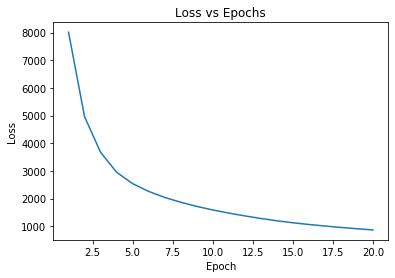

In [32]:
plt.plot(np.arange(1,21), loss_list)
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test

In [35]:
test_length = len(X_test)
loss = 0 
accuracy = 0
gt_list = []
pred_list = []
for input_data, label in zip(X_test, Y_test):
    input_data = input_data.reshape(1,28,28,1)
    label = np.array([label])
    label_oh = (np.eye(10)[label.astype(int)]).reshape(1,10)
    # Forward Propogation
    output = input_data.copy()
    for layer in model:
        output = layer.forward(output)
    assert output.shape == label_oh.shape, "Network Output and Label Dim Don't Match"
    # Accuracy Check
    accuracy += np.mean(label == np.argmax(output, axis=1))
    gt_list.append(label)
    pred_list.append(np.argmax(output,axis=1))
print('Test accuracy : ', accuracy/test_length)

Test accuracy :  0.9166666666666666


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report

In [40]:
print("Classification Report\n")
print(classification_report(gt_list, pred_list))

Classification Report

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       122
         1.0       0.99      0.98      0.99       135
         2.0       0.84      0.91      0.87       110
         3.0       0.95      0.79      0.87       106
         4.0       0.98      0.90      0.94       136
         5.0       0.89      0.89      0.89        96
         6.0       0.91      0.96      0.93       110
         7.0       0.97      0.92      0.94       156
         8.0       0.79      0.88      0.83       110
         9.0       0.87      0.96      0.91       119

    accuracy                           0.92      1200
   macro avg       0.92      0.91      0.91      1200
weighted avg       0.92      0.92      0.92      1200



# Confusion Matrix

In [41]:
print("Confusion Matrix\n")
print(confusion_matrix(gt_list, pred_list))

Confusion Matrix

[[116   0   2   0   1   1   1   0   1   0]
 [  0 132   1   0   0   0   0   0   2   0]
 [  1   1 100   2   1   0   0   1   3   1]
 [  0   0   4  84   0   7   0   2   9   0]
 [  0   0   3   0 123   0   3   0   0   7]
 [  1   0   1   0   0  85   4   0   4   1]
 [  1   0   0   0   0   1 106   0   2   0]
 [  1   0   3   0   0   0   1 143   2   6]
 [  1   0   4   2   0   2   2   0  97   2]
 [  0   0   1   0   0   0   0   1   3 114]]


# Test on images

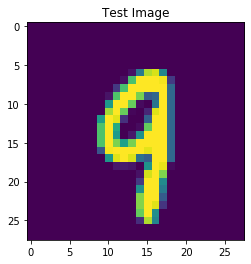

Predicted Label :  [9]
Ground truth label :  9.0


In [42]:
TEST_IMG_NO = 100
test_img = X_test[TEST_IMG_NO]
test_img = np.reshape(test_img, (1,28,28,1)) # adding batch dimension to image
plt.imshow(test_img[0,:,:,0])
plt.title("Test Image")
plt.show()

output = test_img.copy()
for layer in model:
    output = layer.forward(output)
pred_label = np.argmax(output, axis=1)
gt_label = Y_test[TEST_IMG_NO]

print("Predicted Label : ", pred_label)
print("Ground truth label : ", gt_label)

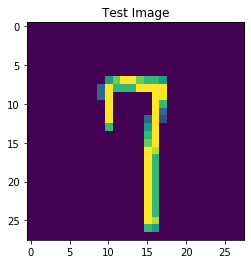

Predicted Label :  [7]
Ground truth label :  7.0


In [43]:
TEST_IMG_NO = 10
test_img = X_test[TEST_IMG_NO]
test_img = np.reshape(test_img, (1,28,28,1)) # adding batch dimension to image
plt.imshow(test_img[0,:,:,0])
plt.title("Test Image")
plt.show()

output = test_img.copy()
for layer in model:
    output = layer.forward(output)
pred_label = np.argmax(output,axis=1)
gt_label = Y_test[TEST_IMG_NO]

print("Predicted Label : ", pred_label)
print("Ground truth label : ", gt_label)